In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares, brute
import random
import numdifftools as nd
from tabulate import tabulate

## First and Second Order Methods

In [243]:
def generate_ab(seed=None):
    if seed != None:
        random.seed(seed)
    return random.random(), random.random()
    
def generate_noisy(a, b):
    x = np.array([k/100 for k in range(100)])
    y = np.array([(a * xk + b + np.random.normal(0,1)) for xk in x])
    
    return x, y
    
def _linear(a, b, x):
    return a * x + b

def _rational(a, b, x):
    return a / (1 + b * x)

def linear(init_point, *args):
    '''please pass x and y into *args'''
    a, b = init_point
    x, y = args[0], args[1]    
    return np.sum((_linear(a,b,x) - y)**2)

def rational(init_point, *args):
    '''please pass x and y into *args'''
    a, b = init_point
    x, y = args[0], args[1]
    return np.sum((_rational(a, b, x) - y)**2)

def linear_resid(init_point, *args):
    a, b = init_point
    x, y = args[0], args[1]
    return abs(_linear(a, b, x) - y)

def rational_resid(init_point, *args):
    a, b = init_point
    x, y = args[0], args[1]
    return abs(_rational(a, b, x) - y)

[0.62290169 0.74178699]


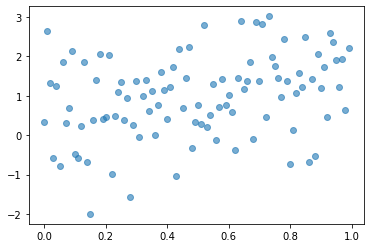

In [368]:
a, b = generate_ab(5)
x, y = generate_noisy(a, b)
yk = a * x + b
init_point = np.array([a, b])
print(init_point)

plt.scatter(x, y, alpha=0.6)
plt.show()

### Gradient Descent

In [360]:
def gradient_descent(fx, init_point, x, y, e, alpha=1e-4):

    iter, f_iter = 0, 0

    while True:
        gradient = nd.Gradient(fx)(init_point, x, y)
        derivative = init_point - alpha * gradient        

        iter += 1
        f_iter += 1

        # if abs(derivative[0] - init_point[0]) > e or abs(derivative[1] - init_point[1]) > e:
        deriv_mag = np.sqrt((derivative[0]-init_point[0])**2 + (derivative[1]-init_point[1])**2)
        # print(deriv_mag, iter)
        if deriv_mag > e:
            init_point = derivative
        else:
            break

    init_point = derivative
    
    return init_point, iter, f_iter

In [481]:
print('Gradient Descent on linear function')
gd_linear = gradient_descent(linear, init_point, x, y, 0.001, alpha=0.0075)
print(f'Current function value: {linear(gd_linear[0], x, y)}')
print(f'Iterations: {gd_linear[1]}')
print(f'Function Calls: {gd_linear[2]}')
print(gd_linear[0], end='\n\n')


print('Gradient Descent on rational function')
gd_rational = gradient_descent(rational, init_point, x, y, 0.001, alpha=0.001)
print(f'Current function value: {rational(gd_rational[0], x, y)}')
print(f'Iterations: {gd_rational[1]}')
print(f'Function Calls: {gd_rational[2]}')
print(gd_rational[0])

Gradient Descent on linear function
Current function value: 98.82167186352936
Iterations: 45
Function Calls: 45
[1.09801939 0.42970866]

Gradient Descent on rational function
Current function value: 99.06239065851287
Iterations: 121
Function Calls: 121
[ 0.61793714 -0.6408036 ]


### Conjugate Gradient Descent

In [440]:
print('Conjugate Gradient Descent on Linear function')
conjugate_linear = minimize(linear, [a, b], args=(x, y), method='CG', tol=0.001, options={'disp': True})
print(conjugate_linear['x'], end='\n\n')

print('Conjugate Gradient Descent on Linear function')
conjugate_rational = minimize(rational, [a, b], args=(x, y), method='CG', tol=0.001, options={'disp': True})
print(conjugate_rational['x'])

Conjugate Gradient Descent on Linear function
Optimization terminated successfully.
         Current function value: 98.821477
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
[1.10280355 0.42755065]

Conjugate Gradient Descent on Linear function
Optimization terminated successfully.
         Current function value: 99.057699
         Iterations: 12
         Function evaluations: 93
         Gradient evaluations: 31
[ 0.61033604 -0.6484684 ]


### Newton's Method

In [441]:
print('Newton on Linear function')
newton_linear = minimize(linear, init_point, args=(x, y), method='BFGS', tol=0.001, options={'disp': True})
print(newton_linear['x'], end='\n\n')

print('Newton on Rational function')
newton_rational = minimize(rational, init_point, args=(x, y), method='BFGS', tol=0.001, options={'disp': True})
print(newton_rational['x'])

Newton on Linear function
Optimization terminated successfully.
         Current function value: 98.821477
         Iterations: 3
         Function evaluations: 15
         Gradient evaluations: 5
[1.10280336 0.42755075]

Newton on Rational function
Optimization terminated successfully.
         Current function value: 99.057699
         Iterations: 10
         Function evaluations: 57
         Gradient evaluations: 19
[ 0.61033807 -0.64846684]


### Levenberg-Marquadt

In [442]:
print('Levenberg-Marquadt on Linear function')
levenberg_linear = least_squares(linear_resid, init_point, args=(x, y), method='lm', xtol=0.001)
print(f'Current function value: {levenberg_linear["cost"]}')
print(f'Function Calls: {levenberg_linear["nfev"]}')
print(levenberg_linear['x'], end='\n\n')


print('Levenberg-Marquadt on Rational function')
levenberg_rational = least_squares(rational_resid, init_point, args=(x, y), method='lm', xtol=0.001)
print(f'Current function value: {levenberg_rational["cost"]}')
print(f'Function Calls: {levenberg_rational["nfev"]}')
print(levenberg_rational['x'], end='\n\n')

Levenberg-Marquadt on Linear function
Current function value: 49.41073837541296
Function Calls: 6
[1.1028033  0.42755078]

Levenberg-Marquadt on Rational function
Current function value: 49.52884944967171
Function Calls: 28
[ 0.61032405 -0.648483  ]



## Direct Methods

### Exhaustive

In [443]:
grid = (slice(a, b, 0.001), slice(a, b, 0.001))

print('Exhaustive Search on Linear function')
exhaustive_linear = brute(linear, grid, args=(x, y), disp=True, full_output=True)
print(exhaustive_linear[0], end='\n\n')

print('Exhaustive Search on Rational function')
exhaustive_rational = brute(rational, grid, args=(x, y), disp=True, full_output=True)
print(exhaustive_rational[0])

Exhaustive Search on Linear function
Optimization terminated successfully.
         Current function value: 98.821477
         Iterations: 30
         Function evaluations: 59
[1.10276201 0.42757062]

Exhaustive Search on Rational function
Optimization terminated successfully.
         Current function value: 99.057699
         Iterations: 43
         Function evaluations: 84
[ 0.61038474 -0.64839075]


### Nelder-Mead

In [446]:
print('Nelder-Mead on Linear function')
nelder_linear = minimize(linear, [a, b], args=(x, y), method='nelder-mead', tol=0.001, options={'disp': True})
print(nelder_linear['x'], end='\n\n')

print('Nelder-Mead on Rational function')
nelder_rational = minimize(rational, [a, b], args=(x, y), method='nelder-mead', tol=0.001, options={'disp': True})
print(nelder_rational['x'])

Nelder-Mead on Linear function
Optimization terminated successfully.
         Current function value: 98.821478
         Iterations: 29
         Function evaluations: 56
[1.10306299 0.4275054 ]

Nelder-Mead on Rational function
Optimization terminated successfully.
         Current function value: 99.057724
         Iterations: 38
         Function evaluations: 69
[ 0.610627   -0.64796398]


### Gauss

In [447]:
print('Gauss (coordinate descent) on Linear function')
gauss_linear = minimize(linear, [a, b], args=(x, y), method='Powell', tol=0.001, options={'disp': True})
print(gauss_linear['x'], end='\n\n')

print('Gauss (coordinate descent) on Rational function')
gauss_rational = minimize(rational, [a, b], args=(x, y), method='Powell', tol=0.001, options={'disp': True})
print(gauss_rational['x'])

Gauss (coordinate descent) on Linear function
Optimization terminated successfully.
         Current function value: 98.821477
         Iterations: 3
         Function evaluations: 73
[1.10279059 0.42749733]

Gauss (coordinate descent) on Rational function
Optimization terminated successfully.
         Current function value: 99.060119
         Iterations: 4
         Function evaluations: 91
[ 0.61501603 -0.64612463]


## Table Report

In [482]:
headers = ['a', 'b', 'Fx value', 'Iterations', 'Fx calls']
index = ['Gradient Descent', 'Conjugate GD', 'Newton', 'Levenberg', 'Exhaustive', 'Gauss', 'Nelder-Mead']
table_linear = [
    [gd_linear[0][0], gd_linear[0][1], linear(gd_linear[0], x, y), gd_linear[1], gd_linear[2]],
    [conjugate_linear['x'][0], conjugate_linear['x'][1], conjugate_linear['fun'], conjugate_linear['nit'], conjugate_linear['nfev']],
    [newton_linear['x'][0], newton_linear['x'][1], newton_linear['fun'], newton_linear['nit'], newton_linear['nfev']],
    [levenberg_linear['x'][0], levenberg_linear['x'][1], levenberg_linear['cost'], levenberg_linear['nfev'], levenberg_linear['nfev']],
    [exhaustive_linear[0][0], exhaustive_linear[0][1], exhaustive_linear[1], len(exhaustive_linear[3]), len(exhaustive_linear[3])],
    [gauss_linear['x'][0], gauss_linear['x'][1], gauss_linear['fun'], gauss_linear['nit'], gauss_linear['nfev']],
    [nelder_linear['x'][0], nelder_linear['x'][1], nelder_linear['fun'], nelder_linear['nit'], nelder_linear['nfev']],
]

table_rational = [
    [gd_rational[0][0], gd_rational[0][1], rational(gd_rational[0], x, y), gd_rational[1], gd_rational[2]],
    [conjugate_rational['x'][0], conjugate_rational['x'][1], conjugate_rational['fun'], conjugate_rational['nit'], conjugate_rational['nfev']],
    [newton_rational['x'][0], newton_rational['x'][1], newton_rational['fun'], newton_rational['nit'], newton_rational['nfev']],
    [levenberg_rational['x'][0], levenberg_rational['x'][1], levenberg_rational['cost'], levenberg_rational['nfev'], levenberg_rational['nfev']],
    [exhaustive_rational[0][0], exhaustive_rational[0][1], exhaustive_rational[1], len(exhaustive_rational[3]), len(exhaustive_rational[3])],
    [gauss_rational['x'][0], gauss_rational['x'][1], gauss_rational['fun'], gauss_rational['nit'], gauss_rational['nfev']],
    [nelder_rational['x'][0], nelder_rational['x'][1], nelder_rational['fun'], nelder_rational['nit'], nelder_rational['nfev']],
]

In [483]:
print('Linear Table Comparison')
print(tabulate(table_linear, headers=headers, showindex=index), end='\n\n\n')

print('Rational Table Comparison')
print(tabulate(table_rational, headers=headers, showindex=index))

Linear Table Comparison
                        a         b    Fx value    Iterations    Fx calls
----------------  -------  --------  ----------  ------------  ----------
Gradient Descent  1.09802  0.429709     98.8217            45          45
Conjugate GD      1.1028   0.427551     98.8215             2          15
Newton            1.1028   0.427551     98.8215             3          15
Levenberg         1.1028   0.427551     49.4107             6           6
Exhaustive        1.10276  0.427571     98.8215           119         119
Gauss             1.10279  0.427497     98.8215             3          73
Nelder-Mead       1.10306  0.427505     98.8215            29          56


Rational Table Comparison
                         a          b    Fx value    Iterations    Fx calls
----------------  --------  ---------  ----------  ------------  ----------
Gradient Descent  0.617937  -0.640804     99.0624           121         121
Conjugate GD      0.610336  -0.648468     99.0577     

## Plot

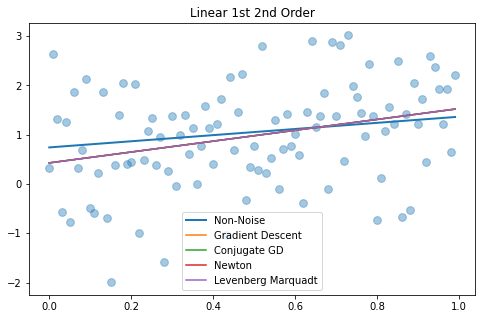

In [484]:
plt.figure(figsize=(8,5))
plt.title('Linear 1st 2nd Order')
plt.scatter(x, y, alpha=0.4, s=60)
plt.plot(x, yk, linewidth=2, label='Non-Noise')
plt.plot(x, _linear(gd_linear[0][0], gd_linear[0][1], x), label='Gradient Descent')
plt.plot(x, _linear(conjugate_linear['x'][0], conjugate_linear['x'][1], x), label='Conjugate GD')
plt.plot(x, _linear(newton_linear['x'][0], newton_linear['x'][1], x), label='Newton')
plt.plot(x, _linear(levenberg_linear['x'][0], levenberg_linear['x'][1], x), label='Levenberg Marquadt')
plt.legend()
plt.show()

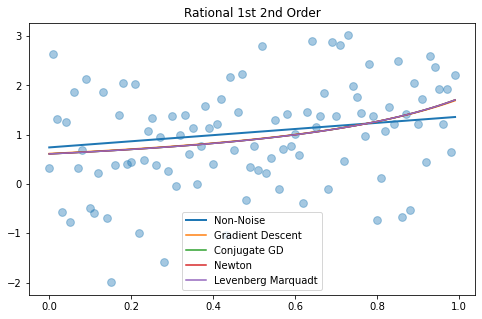

In [485]:
plt.figure(figsize=(8,5))
plt.title('Rational 1st 2nd Order')
plt.scatter(x, y, alpha=0.4, s=60)
plt.plot(x, yk, linewidth=2, label='Non-Noise')
plt.plot(x, _rational(gd_rational[0][0], gd_rational[0][1], x), label='Gradient Descent')
plt.plot(x, _rational(conjugate_rational['x'][0], conjugate_rational['x'][1], x), label='Conjugate GD')
plt.plot(x, _rational(newton_rational['x'][0], newton_rational['x'][1], x), label='Newton')
plt.plot(x, _rational(levenberg_rational['x'][0], levenberg_rational['x'][1], x), label='Levenberg Marquadt')
plt.legend()
plt.show()

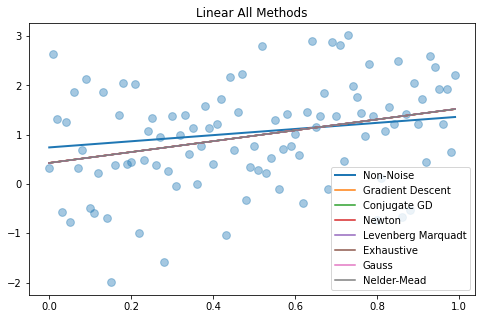

In [486]:
plt.figure(figsize=(8,5))
plt.title('Linear All Methods')
plt.scatter(x, y, alpha=0.4, s=60)
plt.plot(x, yk, linewidth=2, label='Non-Noise')
# 1st 2nd order
plt.plot(x, _linear(gd_linear[0][0], gd_linear[0][1], x), label='Gradient Descent')
plt.plot(x, _linear(conjugate_linear['x'][0], conjugate_linear['x'][1], x), label='Conjugate GD')
plt.plot(x, _linear(newton_linear['x'][0], newton_linear['x'][1], x), label='Newton')
plt.plot(x, _linear(levenberg_linear['x'][0], levenberg_linear['x'][1], x), label='Levenberg Marquadt')
# direct methods
plt.plot(x, _linear(exhaustive_linear[0][0], exhaustive_linear[0][1], x), label='Exhaustive')
plt.plot(x, _linear(gauss_linear['x'][0], gauss_linear['x'][1], x), label='Gauss')
plt.plot(x, _linear(nelder_linear['x'][0], nelder_linear['x'][1], x), label='Nelder-Mead')
plt.legend()
plt.show()

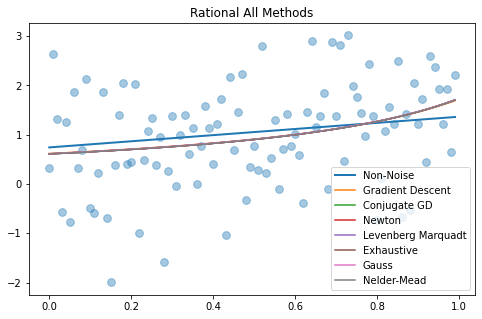

In [487]:
plt.figure(figsize=(8,5))
plt.title('Rational All Methods')
plt.scatter(x, y, alpha=0.4, s=60)
plt.plot(x, yk, linewidth=2, label='Non-Noise')
# 1st 2nd order methods
plt.plot(x, _rational(gd_rational[0][0], gd_rational[0][1], x), label='Gradient Descent')
plt.plot(x, _rational(conjugate_rational['x'][0], conjugate_rational['x'][1], x), label='Conjugate GD')
plt.plot(x, _rational(newton_rational['x'][0], newton_rational['x'][1], x), label='Newton')
plt.plot(x, _rational(levenberg_rational['x'][0], levenberg_rational['x'][1], x), label='Levenberg Marquadt')
# direct methods
plt.plot(x, _rational(exhaustive_rational[0][0], exhaustive_rational[0][1], x), label='Exhaustive')
plt.plot(x, _rational(gauss_rational['x'][0], gauss_rational['x'][1], x), label='Gauss')
plt.plot(x, _rational(nelder_rational['x'][0], nelder_rational['x'][1], x), label='Nelder-Mead')
plt.legend()
plt.show()